# EDA and Time Series Model Fitting
---
This notebook is concerned with exploring a few representative grids of the ERA5 dataset (places with constant low wind speeds and constant high speeds). The ACF, PACF, and stationarity are checked as well. The models used are Naive, Windowed, Exponential Moving Average, ARIMA, Prophet, and LSTM.

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse, meanabs
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from fbprophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [117]:
df = pd.read_pickle("results/era0820_100m.pkl")
df["date"] = pd.to_datetime(df["date"])
df

,date,lat,lon,windvelo
0,2008-01-01,21.50,116.5,11.287799
1,2008-01-01,21.25,116.5,11.269390
2,2008-01-01,21.00,116.5,11.237897
3,2008-01-01,20.75,116.5,11.260742
4,2008-01-01,20.50,116.5,11.333221
...,...,...,...,...
498415,2020-12-01,5.00,127.5,1.671269
498416,2020-12-01,4.75,127.5,1.614607
498417,2020-12-01,4.50,127.5,1.562249
498418,2020-12-01,4.25,127.5,1.502779


In [118]:
# Somewhere in Antique
maxv_df = df[(df.lon == 122.0) \
             & (df.lat == 11.75)] \
            .set_index("date", drop=True) \
            .drop(columns=["lat", "lon"])
maxv_df

,windvelo
date,
2008-01-01,9.513057
2008-02-01,10.080398
2008-03-01,8.008327
2008-04-01,7.624721
2008-05-01,4.655556
...,...
2020-08-01,3.281062
2020-09-01,1.326175
2020-10-01,1.824418


In [119]:
# Somewhere in Davao
minv_df = df[(df.lon == 124.75) \
             & (df.lat == 6.75)].set_index("date", drop=True)
minv_df

,lat,lon,windvelo
date,,,
2008-01-01,6.75,124.75,0.193310
2008-02-01,6.75,124.75,0.279057
2008-03-01,6.75,124.75,0.435242
2008-04-01,6.75,124.75,0.377758
2008-05-01,6.75,124.75,0.338360
...,...,...,...
2020-08-01,6.75,124.75,0.110444
2020-09-01,6.75,124.75,0.168118
2020-10-01,6.75,124.75,0.415854


In [120]:
def convert_to_dict(lst):
    res_dct = {i+1: lst[i] for i in range(0, len(lst))}
    return res_dct

In [121]:
def get_acf_lag(df, nlags=12):
    acf = sm.tsa.acf(df, nlags=nlags, alpha=0.05, qstat=True, fft=False)

    confidence_intervals = acf[1]
    p_values = convert_to_dict(acf[3])

    lag = min(p_values, key=p_values.get)
    p_value = p_values[lag]
    acf = np.mean(confidence_intervals[lag-1])

    return { "lag": int(lag), "acf": acf, "p_value": p_value }

In [122]:
def test_stationarity(timeseries, window=12, cutoff=0.01):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag=20)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

In [123]:
def plot_autocorrelations(df, lags=12):
    acf_info = get_acf_lag(df, nlags=lags)
    print("Lag: %d, ACF: %.08f, p-value:" % (acf_info["lag"], acf_info["acf"]))
    print(acf_info["p_value"])

    fig = plt.figure(figsize=(10,3))
    ax = fig.add_subplot(111)
    plt.plot(df)

    fig = plt.figure(figsize=(10,6))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    acf = plot_acf(df, lags=lags, ax=ax1)
    pacf = plot_pacf(df, lags=lags, ax=ax2)
    
    test_stationarity(df)

Lag: 36, ACF: 0.04046662, p-value:
1.8638168267255062e-23


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


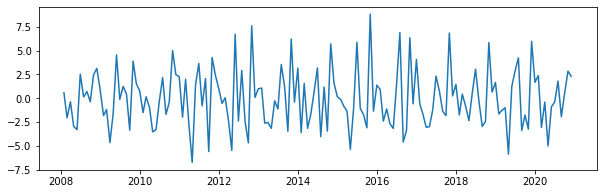

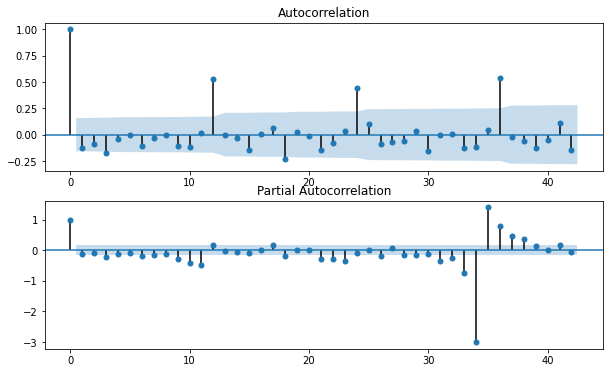

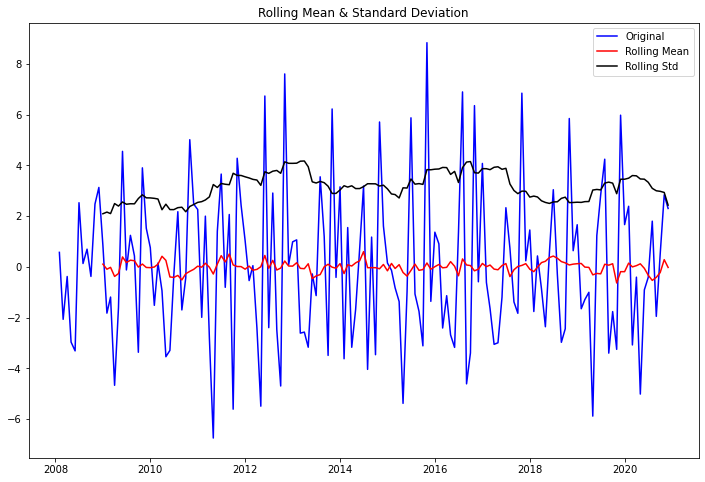

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -7.244033e+00
p-value                        1.852256e-10
#Lags Used                     1.100000e+01
Number of Observations Used    1.430000e+02
Critical Value (1%)           -3.476927e+00
Critical Value (5%)           -2.881973e+00
Critical Value (10%)          -2.577665e+00
dtype: float64


In [124]:
plot_autocorrelations(maxv_df["windvelo"].interpolate().diff()[1:], 42)

Lag: 36, ACF: -0.06863176, p-value:
1.2236829588580213e-06


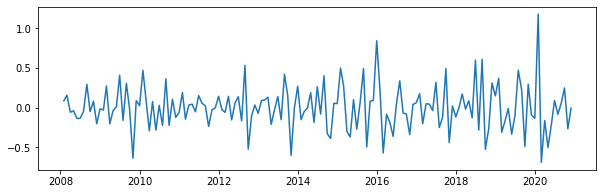

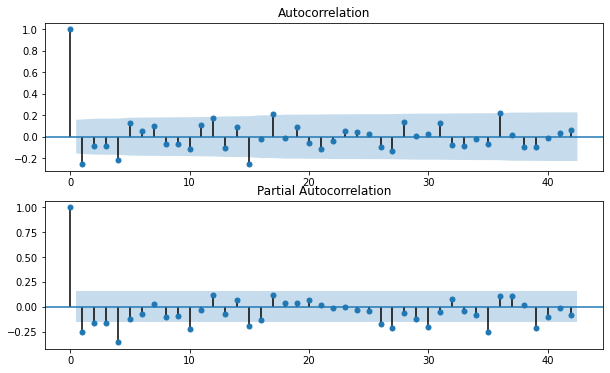

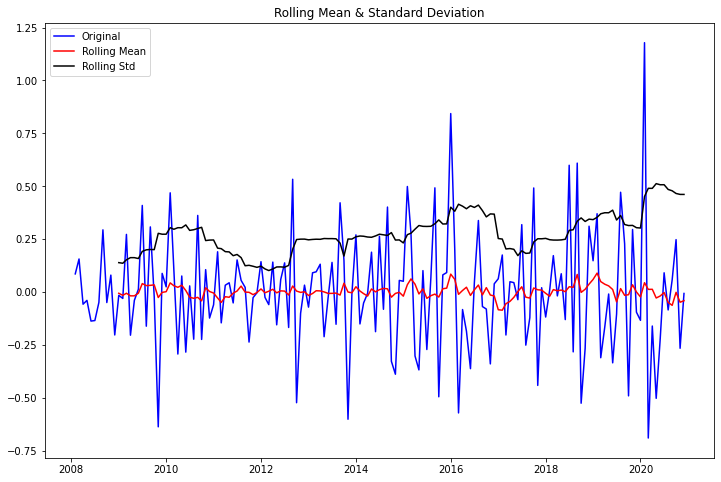

Results of Dickey-Fuller Test:
p-value = 0.0034. The series is likely stationary.
Test Statistic                  -3.755967
p-value                          0.003391
#Lags Used                      16.000000
Number of Observations Used    138.000000
Critical Value (1%)             -3.478648
Critical Value (5%)             -2.882722
Critical Value (10%)            -2.578065
dtype: float64


In [125]:
plot_autocorrelations(minv_df["windvelo"].interpolate().diff()[1:], 42)

In [126]:
def plot_original(train_df, test_df, feature="windvelo"):
    fig = plt.figure(figsize=(10,3))
    ax = fig.add_subplot(111)

    train_df[feature].plot(color="C7", ax=ax, label="train")
    test_df[feature].plot(color="C0", ax=ax, label="test")

    plt.legend()
    plt.ylabel("wind speed at a sector")

In [128]:
def get_naive_forecast(df, start_date):
    return df.shift(1)[start_date:]

In [129]:
def get_windowed_forecast(df, start_date, roll_value=12):
    return df.rolling(roll_value).mean().shift(1)[start_date:]

In [130]:
def get_ema_forecast(df, start_date, alpha=0.7):
    # alpha = 1 is similar to naive
    return df.ewm(alpha=alpha).mean().shift(1)[start_date:]

In [131]:
def get_arima_fit(train_df, feature, order):
    model = ARIMA(endog=train_df[feature], order=order)  
    return model.fit()

In [132]:
def get_arima_forecast(model_fit, test_count, feature):
    return pd.DataFrame(model_fit.forecast(test_count, dynamic=True))\
                .rename(columns={"predicted_mean": feature})

In [133]:
# Prophet accepts a certain column signature
def serialize_prophet(df, feature):
    df = df.reset_index()
    fb_df = pd.DataFrame(columns=["ds", "y"])
    fb_df["ds"] = pd.to_datetime(df["date"])
    fb_df["y"] = df[feature]
    return fb_df

In [134]:
def get_prophet_forecast(train_df, test_df):
    model = Prophet()
    model.fit(train_df)
    forecast = model.predict(test_df)
#     print(forecast.columns)
#     model.plot(forecast)
#     model.plot_components(forecast)
    return forecast

In [135]:
# The fb_feature we will use is yhat. Other features exist such as yhat_lower and yhat_upper.
def unserialize_prophet(df, fb_feature, feature):
    df = df.rename(columns={"ds": "date", fb_feature: feature}).set_index("date", drop=True)
    return df[[feature]]

In [136]:
# LSTM model accepts a dataset matrix
# This method produces 2 matrices X and Y
# where Y value at time t is the X value at time t + look back value
def prepare_for_lstm(df, look_back=1):
    X, Y = [], []
    for i in range(len(df)-look_back):
        X.append(df[i:(i+1)])
        Y.append(df[(i+look_back):(i+look_back+1)])
    return np.array(X), np.array(Y)

In [137]:
# LSTM model outputs a dataset matrix as well
# This method unpacks the forecast matrix using the test data as pattern
# This method also accepts a scaler to inverse the action during preparation
def unpack_forecast_matrix(lstm_matrix, test_df_pattern, scaler=None):
    forecast_len = len(lstm_matrix)
    forecast_df = test_df_pattern.iloc[:forecast_len]
    raw_forecast = []
    for i in range(forecast_len):
        raw_forecast.append(lstm_matrix[i][0])
    if scaler != None:
        raw_forecast = scaler.inverse_transform(raw_forecast)
    forecast_df.iloc[:, 1] = raw_forecast
    return forecast_df

In [138]:
def get_lstm_forecast(train_df, test_df, feature="windvelo", \
                      time_step=1, lstm_units=50, activation="relu", \
                      dense_units=1, epochs=100, verbose=0):
    trainX, trainY = prepare_for_lstm(train_df[[feature]], look_back=time_step)

    # Since testY won't be used in this version of LSTM sequence,
    # we refrained from setting a look back value to prevent the trimming of the testX length
    testX, testY = prepare_for_lstm(test_df[[feature]], look_back=0)

    # reshape input to be [sample count, time steps, feature count]
    trainX = np.reshape(trainX, (trainX.shape[0], time_step, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], time_step, testX.shape[1]))

    model = Sequential()
    model.add(LSTM(units=lstm_units, activation=activation, return_sequences=True, \
                   input_shape=(testX.shape[1], testX.shape[2])))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=lstm_units, activation=activation, return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=lstm_units, activation=activation, return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=lstm_units, activation=activation, return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=dense_units))
    model.compile(optimizer="adam", loss="mse")
    
    model.fit(trainX, trainY, epochs=epochs, verbose=verbose)

    # make predictions
    # trainPredict = model.predict(trainX)
    return model.predict(testX)

In [139]:
def plot_forecast(train_df, test_df, forecast_df, feature):
    fig = plt.figure(figsize=(10,3))
    ax = fig.add_subplot(111)

    train_df[feature].plot(color="C7", ax=ax, label="train")
    test_df[feature].plot(color="C0", ax=ax, label="test")

    forecast_df[feature].plot(color="C1", ax=ax, label="forecast")

    plt.legend()
    plt.ylabel("wind velocity at a sector")

    print("The RMSE is %0.4f" % rmse(test_df[feature], forecast_df[feature]))
    print("The MAE is %0.4f" % meanabs(test_df[feature], forecast_df[feature]))
    print("The R2 score is %0.4f" % r2_score(test_df[feature], forecast_df[feature]))

In [140]:
maxv_train_df = maxv_df["2008-01-01":"2017-12-01"]
maxv_test_df = maxv_df["2018-01-01":]
minv_train_df = minv_df["2008-01-01":"2017-12-01"]
minv_test_df = minv_df["2018-01-01":]

In [141]:
len(maxv_train_df), len(maxv_test_df), len(minv_train_df), len(minv_test_df)

(120, 36, 120, 36)

In [142]:
maxv_diff_df = maxv_df.diff().dropna()
maxdiff_train_df = maxv_diff_df["2008-01-01":"2017-12-01"]
maxdiff_test_df = maxv_diff_df["2018-01-01":]

minv_diff_df = minv_df.diff().dropna()
mindiff_train_df = minv_diff_df["2008-01-01":"2017-12-01"]
mindiff_test_df = minv_diff_df["2018-01-01":]

In [143]:
len(maxdiff_train_df), len(maxdiff_test_df), len(mindiff_train_df), len(mindiff_test_df)

(119, 36, 119, 36)

In [144]:
maxv_head_df = maxv_train_df.tail(1)
minv_head_df = minv_train_df.tail(1)
maxv_head_df, minv_head_df

(            windvelo
 date                
 2017-12-01  8.351656,
              lat     lon  windvelo
 date                              
 2017-12-01  6.75  124.75  0.183423)

In [147]:
test_start_date = "2018-01-01"
months = pd.date_range(start=test_start_date, periods=len(maxv_test_df), freq="MS")
months

DatetimeIndex(['2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [148]:
def inverse_diff(head_df, diff_df, feature="windvelo"):
    return pd.DataFrame(data=head_df.append(diff_df).cumsum().iloc[1:, 0], index=months)

### Sector with Higher Average Wind Speeds

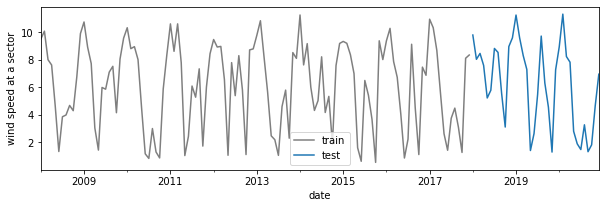

In [145]:
plot_original(maxv_train_df, maxv_test_df, "windvelo")

The RMSE is 2.7374
The MAE is 2.2392
The R2 score is 0.1878


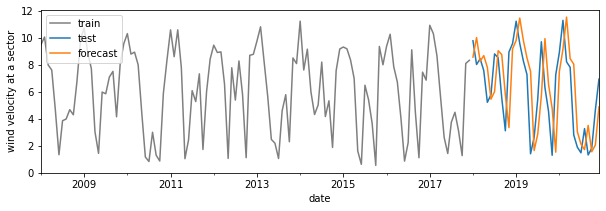

In [151]:
plot_forecast(maxv_train_df,
              maxv_test_df,
              inverse_diff(maxv_head_df, get_naive_forecast(maxv_diff_df, test_start_date)),
              "windvelo")

The RMSE is 4.2395
The MAE is 3.2249
The R2 score is -0.9482


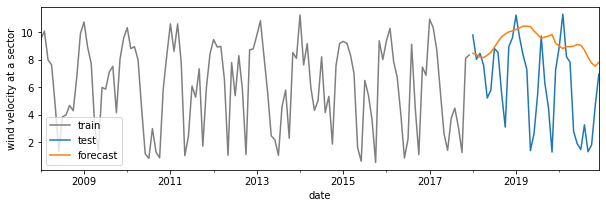

In [152]:
# yearly
plot_forecast(maxv_train_df,
              maxv_test_df,
              inverse_diff(maxv_head_df, get_windowed_forecast(maxv_diff_df, test_start_date)),
              "windvelo")

The RMSE is 5.4604
The MAE is 4.5175
The R2 score is -2.2318


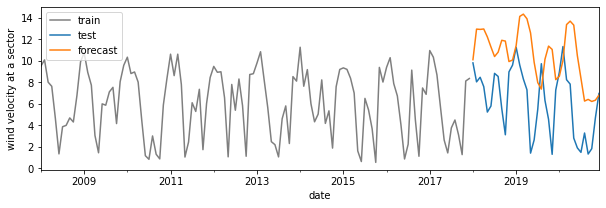

In [153]:
# quarterly
plot_forecast(maxv_train_df,
              maxv_test_df,
              inverse_diff(maxv_head_df, get_windowed_forecast(maxv_diff_df, test_start_date, 3)),
              "windvelo")

The RMSE is 2.7374
The MAE is 2.2392
The R2 score is 0.1878


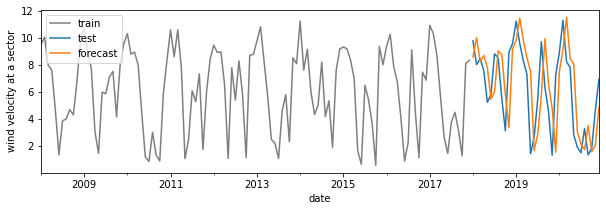

In [154]:
plot_forecast(maxv_train_df,
              maxv_test_df,
              inverse_diff(maxv_head_df, get_ema_forecast(maxv_diff_df, test_start_date, alpha=1)),
              "windvelo")

The RMSE is 3.5486
The MAE is 2.9435
The R2 score is -0.3649


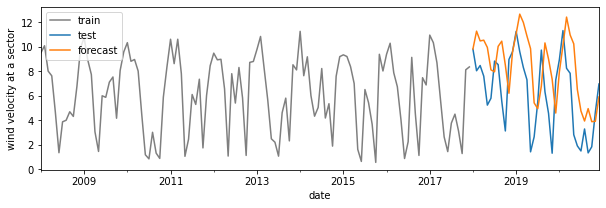

In [157]:
plot_forecast(maxv_train_df,
              maxv_test_df,
              inverse_diff(maxv_head_df, get_ema_forecast(maxv_diff_df, test_start_date, alpha=0.7)),
              "windvelo")

The RMSE is 3.9318
The MAE is 3.2061
The R2 score is -0.6756


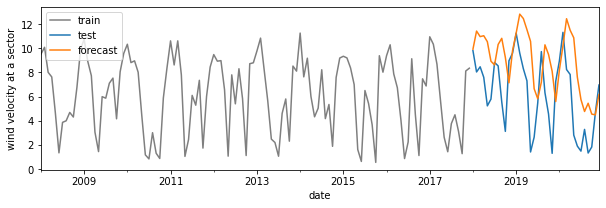

In [158]:
plot_forecast(maxv_train_df,
              maxv_test_df,
              inverse_diff(maxv_head_df, get_ema_forecast(maxv_diff_df, test_start_date, alpha=0.6)),
              "windvelo")

The RMSE is 4.3075
The MAE is 3.5019
The R2 score is -1.0112


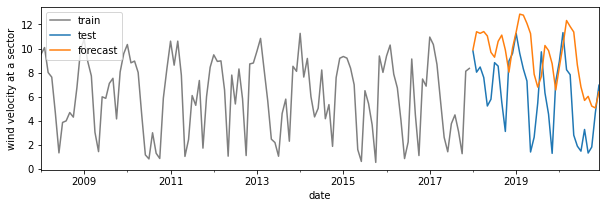

In [159]:
plot_forecast(maxv_train_df,
              maxv_test_df,
              inverse_diff(maxv_head_df, get_ema_forecast(maxv_diff_df, test_start_date, alpha=0.5)),
              "windvelo")

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: 

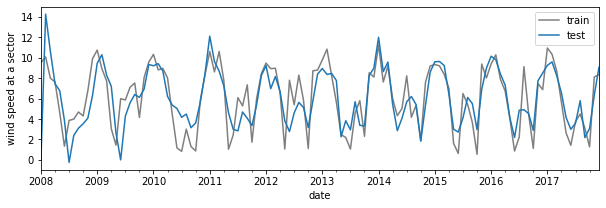

In [237]:
model_fit = get_arima_fit(maxv_train_df, "windvelo", (12, 2, 24))
fitted_df = pd.DataFrame(model_fit.fittedvalues).rename(columns={0: "windvelo"})
plot_original(maxv_train_df, fitted_df, "windvelo")

The RMSE is 2.0948
The MAE is 1.6734
The R2 score is 0.5243


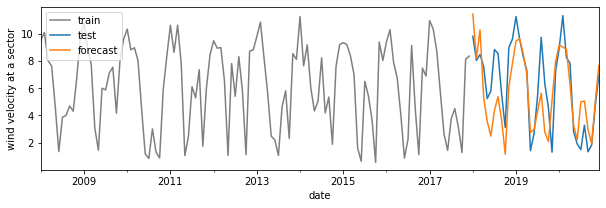

In [238]:
plot_forecast(maxv_train_df,
              maxv_test_df,
              get_arima_forecast(model_fit, len(maxv_test_df), "windvelo"),
              "windvelo")

In [ ]:
#continue here

### Sector with Minimum Average Wind Velocity

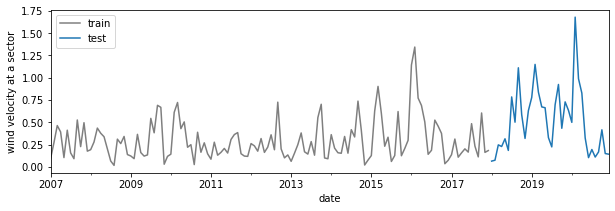

In [281]:
plot_original(minv_train_df, minv_test_df, "windvelo")

The RMSE is 0.3614
The MAE is 0.2720
The R2 score is 0.0072


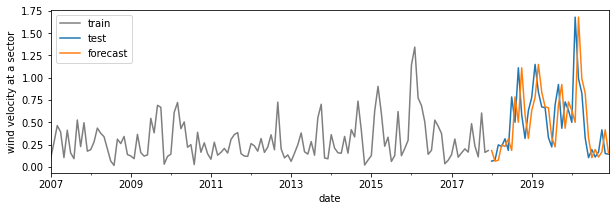

In [863]:
plot_forecast(minv_train_df, minv_test_df, get_naive_forecast(minv_df, "2018-01-01"), "windvelo")

The RMSE is 0.3755
The MAE is 0.2904
The R2 score is -0.0722


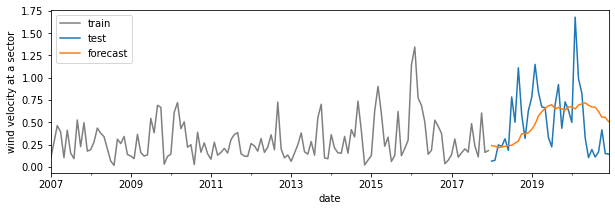

In [864]:
plot_forecast(minv_train_df, minv_test_df, get_windowed_forecast(minv_df, "2018-01-01"), "windvelo") # yearly

The RMSE is 0.3567
The MAE is 0.2634
The R2 score is 0.0324


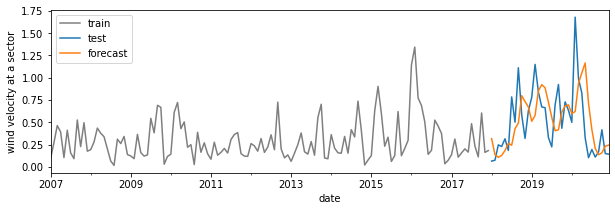

In [865]:
plot_forecast(minv_train_df, minv_test_df, get_windowed_forecast(minv_df, "2018-01-01", 3), "windvelo") # quarterly

The RMSE is 0.3341
The MAE is 0.2511
The R2 score is 0.1514


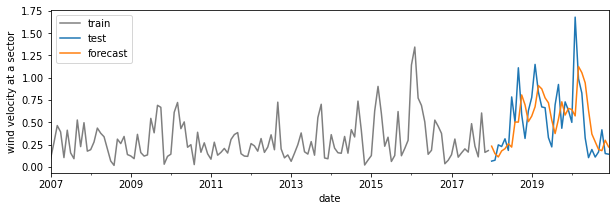

In [866]:
plot_forecast(minv_train_df, minv_test_df, get_ema_forecast(minv_df, "2018-01-01", alpha=0.5), "windvelo")

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: 

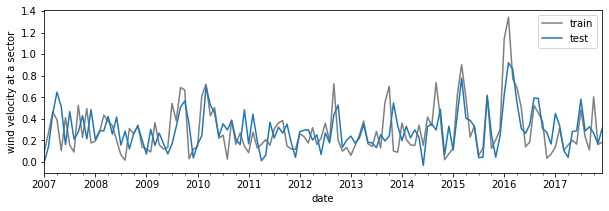

In [867]:
model_fit = get_arima_fit(minv_train_df, "windvelo", (12, 2, 24))
fitted_df = pd.DataFrame(model_fit.fittedvalues).rename(columns={0: "windvelo"})
plot_original(minv_train_df, fitted_df, "windvelo")

The RMSE is 0.3894
The MAE is 0.2868
The R2 score is -0.1529


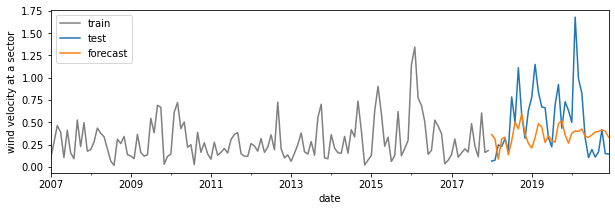

In [868]:
plot_forecast(minv_train_df, minv_test_df, get_arima_forecast(model_fit, len(minv_test_df), "windvelo"), "windvelo")

In [30]:
minv_diff_df["windvelo"]

date
2007-02-01    0.176150
2007-03-01    0.193534
2007-04-01   -0.070947
2007-05-01   -0.287604
2007-06-01    0.306771
                ...   
2020-08-01   -0.084688
2020-09-01    0.057674
2020-10-01    0.247736
2020-11-01   -0.265901
2020-12-01   -0.006814
Name: windvelo, Length: 167, dtype: float64

In [31]:
minv_df["windvelo"].interpolate().diff()

date
2007-01-01         NaN
2007-02-01    0.176150
2007-03-01    0.193534
2007-04-01   -0.070947
2007-05-01   -0.287604
                ...   
2020-08-01   -0.084688
2020-09-01    0.057674
2020-10-01    0.247736
2020-11-01   -0.265901
2020-12-01   -0.006814
Name: windvelo, Length: 168, dtype: float64

The RMSE is 0.3464
The MAE is 0.2566
The R2 score is 0.0875


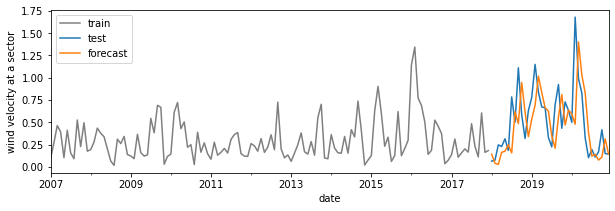

In [32]:
diff_df = get_ema_forecast(minv_diff_df, "2018-01-01", alpha=0.8)
forecast_df = minv_train_df.tail(1)
# print(minv_test_df.head(10))
forecast_df = forecast_df.append(diff_df).cumsum().iloc[1:]
# print(forecast_df)
plot_forecast(minv_train_df, minv_test_df, forecast_df, "windvelo")

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')
The RMSE is 2.1495
The MAE is 1.6662
The R2 score is 0.4992


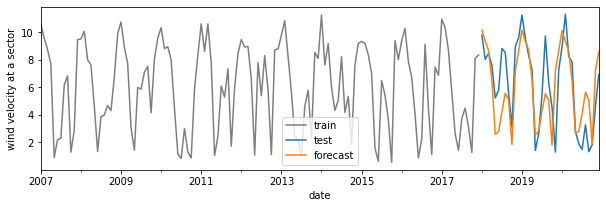

In [869]:
train_df = serialize_prophet(maxv_train_df, "windvelo")
test_df = serialize_prophet(maxv_test_df, "windvelo")
forecast_df = get_prophet_forecast(train_df, test_df)
forecast_y_df = unserialize_prophet(forecast_df, "yhat", "windvelo")
forecast_yl_df = unserialize_prophet(forecast_df, "yhat_lower", "windvelo")
forecast_yu_df = unserialize_prophet(forecast_df, "yhat_upper", "windvelo")
plot_forecast(maxv_train_df, maxv_test_df, forecast_y_df, "windvelo")
# plot_forecast(maxv_train_df, maxv_test_df, forecast_yl_df, "windvelo")
# plot_forecast(maxv_train_df, maxv_test_df, forecast_yu_df, "windvelo")

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')
The RMSE is 0.3686
The MAE is 0.2885
The R2 score is -0.0331


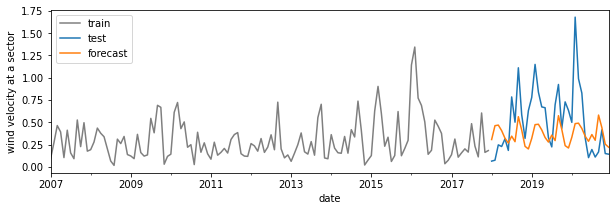

In [870]:
train_df = serialize_prophet(minv_train_df, "windvelo")
test_df = serialize_prophet(minv_test_df, "windvelo")
forecast_df = get_prophet_forecast(train_df, test_df)
forecast_y_df = unserialize_prophet(forecast_df, "yhat", "windvelo")
forecast_yl_df = unserialize_prophet(forecast_df, "yhat_lower", "windvelo")
forecast_yu_df = unserialize_prophet(forecast_df, "yhat_upper", "windvelo")
plot_forecast(minv_train_df, minv_test_df, forecast_y_df, "windvelo")
# plot_forecast(minv_train_df, minv_test_df, forecast_yl_df, "windvelo")
# plot_forecast(minv_train_df, minv_test_df, forecast_yu_df, "windvelo")

The RMSE is 1.4454
The MAE is 1.2430
The R2 score is 0.7735


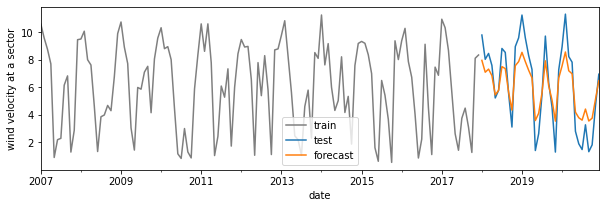

In [36]:
forecast_matrix = get_lstm_forecast(maxv_train_df.reset_index(), maxv_test_df.reset_index())
forecast_df = unpack_forecast_matrix(forecast_matrix, maxv_test_df.reset_index()[["date", "windvelo"]])
plot_forecast(maxv_train_df, maxv_test_df, forecast_df.set_index("date"), "windvelo")

The RMSE is 1.7011
The MAE is 1.5274
The R2 score is 0.6864


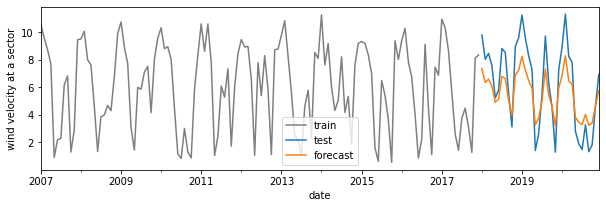

In [37]:
train_df = maxv_train_df.reset_index()
test_df = maxv_test_df.reset_index()
train_df = train_df.append(test_df.iloc[0:1]).reset_index(drop=True)

forecast_matrix = get_lstm_forecast(train_df, test_df)
forecast_df = unpack_forecast_matrix(forecast_matrix, maxv_test_df.reset_index()[["date", "windvelo"]])
plot_forecast(maxv_train_df, maxv_test_df, forecast_df.set_index("date"), "windvelo")

The RMSE is 1.6055
The MAE is 1.3974
The R2 score is 0.7206


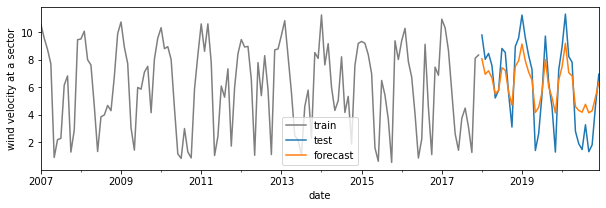

In [38]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_df = maxv_train_df.reset_index()
test_df = maxv_test_df.reset_index()
train_df = train_df.append(test_df.iloc[0:1]).reset_index(drop=True)
train_df["windvelo"] = scaler.fit_transform(train_df[["windvelo"]])
test_df["windvelo"] = scaler.fit_transform(test_df[["windvelo"]])

forecast_matrix = get_lstm_forecast(train_df, test_df, activation="tanh")
forecast_df = unpack_forecast_matrix(forecast_matrix, maxv_test_df.reset_index()[["date", "windvelo"]], scaler)
plot_forecast(maxv_train_df, maxv_test_df, forecast_df.set_index("date"), "windvelo")

The RMSE is 0.2958
The MAE is 0.2341
The R2 score is 0.3346


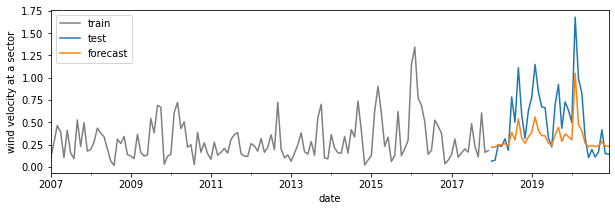

In [39]:
forecast_matrix = get_lstm_forecast(minv_train_df.reset_index(), minv_test_df.reset_index())
forecast_df = unpack_forecast_matrix(forecast_matrix, minv_test_df.reset_index()[["date", "windvelo"]])
plot_forecast(minv_train_df, minv_test_df, forecast_df.set_index("date"), "windvelo")

The RMSE is 0.2516
The MAE is 0.2018
The R2 score is 0.5187


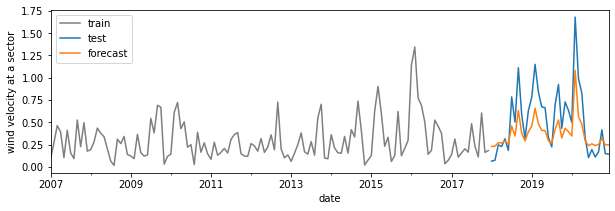

In [40]:
train_df = minv_train_df.reset_index()
test_df = minv_test_df.reset_index()
train_df = train_df.append(test_df.iloc[0:1]).reset_index(drop=True)

forecast_matrix = get_lstm_forecast(train_df, test_df, activation="tanh")
forecast_df = unpack_forecast_matrix(forecast_matrix, minv_test_df.reset_index()[["date", "windvelo"]])
plot_forecast(minv_train_df, minv_test_df, forecast_df.set_index("date"), "windvelo")

The RMSE is 0.2123
The MAE is 0.1786
The R2 score is 0.6575


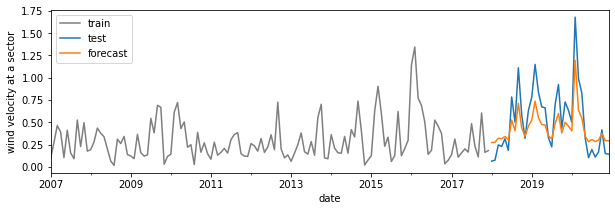

In [41]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_df = minv_train_df.reset_index()
test_df = minv_test_df.reset_index()
train_df = train_df.append(test_df.iloc[0:1]).reset_index(drop=True)
train_df["windvelo"] = scaler.fit_transform(train_df[["windvelo"]])
test_df["windvelo"] = scaler.fit_transform(test_df[["windvelo"]])

forecast_matrix = get_lstm_forecast(train_df, test_df, activation="tanh")
forecast_df = unpack_forecast_matrix(forecast_matrix, minv_test_df.reset_index()[["date", "windvelo"]], scaler)
plot_forecast(minv_train_df, minv_test_df, forecast_df.set_index("date"), "windvelo")

In [44]:
th_train_df = minv_diff_df["2007-01-01":"2017-12-01"]
th_test_df = minv_diff_df["2018-01-01":]

scaler = MinMaxScaler(feature_range=(0, 1))
train_df = th_train_df.reset_index()
test_df = th_test_df.reset_index()
train_df = train_df.append(test_df.iloc[0:1]).reset_index(drop=True)
train_df["windvelo"] = scaler.fit_transform(train_df[["windvelo"]])
test_df["windvelo"] = scaler.fit_transform(test_df[["windvelo"]])

forecast_matrix = get_lstm_forecast(train_df, test_df, activation="tanh")
forecast_df = unpack_forecast_matrix(forecast_matrix, th_test_df.reset_index()[["date", "windvelo"]], scaler)

In [51]:
minv_train_df

,lon,lat,u,v,windvelo
date,,,,,
2007-01-01,124.75,6.75,-0.081486,-0.046266,0.093704
2007-02-01,124.75,6.75,-0.265931,0.045844,0.269854
2007-03-01,124.75,6.75,-0.381564,-0.262938,0.463388
2007-04-01,124.75,6.75,-0.339000,-0.197707,0.392440
2007-05-01,124.75,6.75,0.076357,-0.071834,0.104836
...,...,...,...,...,...
2017-08-01,124.75,6.75,0.208307,-0.105925,0.233691
2017-09-01,124.75,6.75,0.092673,0.063873,0.112553
2017-10-01,124.75,6.75,0.428577,-0.426180,0.604407


            windvelo
date                
2018-01-01  0.301792
2018-02-01  0.412723
2018-03-01  0.514007
2018-04-01  0.626588
2018-05-01  0.732999
2018-06-01  0.852065
2018-07-01  0.926817
2018-08-01  1.054513
2018-09-01  1.128614
2018-10-01  1.269523
2018-11-01  1.396253
2018-12-01  1.489062
2019-01-01  1.591800
2019-02-01  1.680968
2019-03-01  1.810203
2019-04-01  1.931278
2019-05-01  2.043340
2019-06-01  2.173911
2019-07-01  2.291466
2019-08-01  2.374301
2019-09-01  2.472213
2019-10-01  2.611266
2019-11-01  2.705031
2019-12-01  2.822090
2020-01-01  2.941358
2020-02-01  2.977990
2020-03-01  3.127481
2020-04-01  3.248287
2020-05-01  3.387964
2020-06-01  3.512159
2020-07-01  3.618299
2020-08-01  3.734741
2020-09-01  3.842854
2020-10-01  3.939549
2020-11-01  4.066296
2020-12-01  4.178206
The RMSE is 2.0877
The MAE is 1.6963
The R2 score is -32.1377


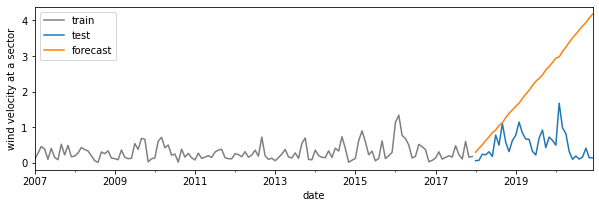

In [54]:
th_forecast_df = minv_train_df[["windvelo"]].tail(1)
th_forecast_df = th_forecast_df.append(forecast_df.set_index("date")).cumsum().iloc[1:]
print(th_forecast_df)
plot_forecast(minv_train_df, minv_test_df, th_forecast_df, "windvelo")